In [1]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import psycopg2
import pycaret
from pycaret.classification import *

## Load Data

In [2]:
# Connect to postgres SQL database
from config import pw
conn = psycopg2.connect(database = 'postgres',
                        user =     'postgres',
                        password = pw,
                        host =     'bootcampproject.cs8v5ggqsbn0.us-west-1.rds.amazonaws.com',
                        port =     '5432')

# Create cursor object
cur = conn.cursor()

# Select all data from machine learning table
cur.execute('''
            SELECT *
            FROM ml_table;
            ''')

data = cur.fetchall()

# Create a dataframe
cols = []
for elt in cur.description:
    cols.append(elt[0])
        
health_df = pd.DataFrame (data=data,columns=cols)
pd.set_option('display.max_columns', None)
health_df.head(10)

,GENHLTH,MENTHLTH,PHYSHLTH,SEX,MARITAL_STATUS,EDUCATION,HOME_STATUS,VETERAN,EMPLOYMENT_SITUATION,INTERNET,DISABILITIES?,USEEQUIP,BLIND,ISSUES_DECISION_MAING,DIFFWALK,DIFFDRES,DIFFALON,HEALTHY_ADULTS,HEALTH_CVRAGE,DIABETE3,BLOOD_PRESSURE,_CHOLCHK,HIGH_CHOLESTEROL,CORONARY_DISEASE,ASTHMA_DISEASE,_ASTHMS1,HAS_ARTHRITIS,RACE,AGE_14LEVEL,BMI,4_BMI,CHILDREN2,EDUCATION_LEVEL,INCOME2,DRINKS_WEEK,HEAVY_DRINKER,FRUIT_CONSUMPTION,VEGGIE_COSUMPTION,PHYS_ACTIVITY_MINS,PHYS_CATEGORIES,PHYS_ACT_INDX,AER_STRGTH
0,3,88,88,2,2,6,1,2,3,1,1,2,1,1,2,2,2,1,2,3,1,2,1,2,1,3,2,1,7,2509,3,1,4,1,0.0,1,2,2,168.0,2,1,2
1,2,88,88,2,3,3,1,2,2,2,1,2,2,2,2,2,2,1,99,3,2,1,1,2,1,3,1,1,11,2652,3,1,1,4,0.0,1,1,1,330.0,1,1,2
2,2,3,88,2,3,5,1,2,7,2,2,2,2,2,2,2,2,1,99,3,2,1,2,2,1,3,2,1,11,2389,2,1,3,2,70.0,1,1,1,345.0,1,1,2
3,2,88,2,1,1,6,1,2,7,1,2,2,2,2,2,2,2,1,99,3,2,1,2,2,1,3,2,1,10,2522,3,1,4,5,0.0,1,1,1,300.0,2,1,2
4,3,88,88,2,3,4,1,2,5,1,1,2,2,2,1,2,2,1,99,3,2,1,2,2,2,1,1,1,11,2500,3,1,2,2,93.0,1,2,1,210.0,2,1,2
5,3,88,14,2,3,3,1,2,7,2,1,1,2,2,2,2,2,1,99,3,2,1,2,1,1,3,1,1,13,2579,3,1,1,99,0.0,1,1,1,90.0,3,2,4
6,3,88,88,1,1,6,1,1,7,1,2,2,2,2,2,2,2,1,99,1,1,1,1,2,1,3,1,1,13,2468,2,1,4,5,23.0,1,1,1,280.0,2,1,2
7,5,99,99,1,2,4,2,1,99,2,1,1,2,2,1,1,1,2,1,1,2,1,2,1,1,3,1,1,99,2848,3,1,2,2,0.0,1,1,1,60.0,3,2,4
8,4,30,28,2,1,6,1,2,8,1,1,2,2,1,2,2,1,2,1,3,1,1,2,2,1,3,1,1,4,3328,4,1,4,1,0.0,1,2,1,0.0,99,99,99
9,2,5,88,2,1,6,1,2,1,1,2,2,2,2,2,2,2,1,1,3,2,1,1,2,1,3,2,1,6,3328,4,1,4,5,93.0,1,2,2,180.0,2,1,1


## Check Preprocessing

In [3]:
# Check size and shape of dataframe
health_df.shape

(222168, 42)

In [4]:
# Check data types
health_df.dtypes

GENHLTH                    int64
MENTHLTH                   int64
PHYSHLTH                   int64
SEX                        int64
MARITAL_STATUS             int64
EDUCATION                  int64
HOME_STATUS                int64
VETERAN                    int64
EMPLOYMENT_SITUATION       int64
INTERNET                   int64
DISABILITIES?              int64
USEEQUIP                   int64
BLIND                      int64
ISSUES_DECISION_MAING      int64
DIFFWALK                   int64
DIFFDRES                   int64
DIFFALON                   int64
HEALTHY_ADULTS             int64
HEALTH_CVRAGE              int64
DIABETE3                   int64
BLOOD_PRESSURE             int64
_CHOLCHK                   int64
HIGH_CHOLESTEROL           int64
CORONARY_DISEASE           int64
ASTHMA_DISEASE             int64
_ASTHMS1                   int64
HAS_ARTHRITIS              int64
RACE                       int64
AGE_14LEVEL                int64
BMI                        int64
4_BMI     

In [5]:
# Double check for null values
health_df.isna().sum().sum()

0

## Feature Engineering

### For numerical, ordered data, change none code (88) to 0, change did not respond codes (7/9/99) to rounded median of the feature, and remove outliers in skewed distributions

In [6]:
# MENTHLTH: 88 (none) changed to 0, 77 (don't know) and 99 (refused) dropped
health_df['MENTHLTH'] = health_df['MENTHLTH'].replace({88:0})
health_df = health_df[health_df.MENTHLTH != 77]
health_df = health_df[health_df.MENTHLTH != 99]
health_df.MENTHLTH.unique()

array([ 0,  3, 30,  5,  7,  1, 15,  2, 25, 10,  4, 20, 14, 12, 21,  6, 16,
       11, 23, 29, 28, 18,  8, 24, 17, 22, 27, 13, 26, 19], dtype=int64)

In [7]:
# Check new number of rows (removed rows where the target value was meaningless)
health_df.shape

(219562, 42)

In [8]:
# PHYSHLTH: 88 (none) changed to 0, 77 (don't know) and 99 (refused) changed to rounded median
PHYSHLTH_median = round(health_df[(health_df.PHYSHLTH != 99) & (health_df.PHYSHLTH != 77)].PHYSHLTH.median())
health_df['PHYSHLTH'] = health_df['PHYSHLTH'].replace({88:0, 77:PHYSHLTH_median, 99:PHYSHLTH_median})
health_df.PHYSHLTH.unique()

array([ 0,  2, 14, 28, 30, 15,  4, 10,  7,  1,  3, 17,  5, 19, 25,  6, 21,
       88, 12, 20,  8, 16, 29, 18, 26, 27, 13, 23, 24, 11, 22],
      dtype=int64)

In [9]:
# AGE_14LEVEL: 14/99 (don't know/refused/missing) changed to rounded median
AGE_median = round(health_df[(health_df.AGE_14LEVEL != 99) & (health_df.AGE_14LEVEL != 14)].AGE_14LEVEL.median())
health_df['AGE_14LEVEL'] = health_df['AGE_14LEVEL'].replace({14:AGE_median, 99:AGE_median})
health_df.AGE_14LEVEL.unique()

array([ 7, 11, 10, 13,  4,  6,  5, 12,  1,  2,  8,  3], dtype=int64)

In [10]:
# BMI: Remove outliers
for index, row in health_df.iterrows():
    if health_df.loc[index, 'BMI'] > 6000:
        health_df.loc[index, 'BMI'] = 6000

In [11]:
# DRINKS_WEEK: Remove outliers
for index, row in health_df.iterrows():
    if health_df.loc[index, 'DRINKS_WEEK'] > 1500:
        health_df.loc[index, 'DRINKS_WEEK'] = 1500

In [12]:
# PHYS_ACTIVITY_MINS: Remove outliers
for index, row in health_df.iterrows():
    if health_df.loc[index, 'PHYS_ACTIVITY_MINS'] > 5000:
        health_df.loc[index, 'PHYS_ACTIVITY_MINS'] = 5000

In [13]:
# For the following columns, remove all 7 (don't know) and 9/99 (refused)
remove_cols = ['GENHLTH','MARITAL_STATUS','HOME_STATUS','EMPLOYMENT_SITUATION','DIABETE3',
               'EDUCATION','VETERAN','INTERNET','DISABILITIES?','USEEQUIP','BLIND','DIFFWALK',
               'DIFFDRES','DIFFALON','HEALTHY_ADULTS','HEALTH_CVRAGE','BLOOD_PRESSURE','_CHOLCHK','HIGH_CHOLESTEROL',
               'ASTHMA_DISEASE','CHILDREN2','EDUCATION_LEVEL','INCOME2','HEAVY_DRINKER','FRUIT_CONSUMPTION',
               'VEGGIE_COSUMPTION','PHYS_CATEGORIES','PHYS_ACT_INDX','AER_STRGTH']

for col in remove_cols:
    filtered_df = health_df[(health_df[col] != 7) & (health_df[col] != 9) & (health_df[col] != 99)]
    median = round(filtered_df[col].median())
    health_df[col] = health_df[col].replace({7:median, 9:median, 99:median})

In [14]:
# For the following columns, change 2 (no) to 0
change_cols_1 = ['SEX','VETERAN','DISABILITIES?','HAS_ARTHRITIS','FRUIT_CONSUMPTION','VEGGIE_COSUMPTION','DIFFDRES',
                 'USEEQUIP','BLIND','DIFFWALK','DIFFALON','CORONARY_DISEASE','INTERNET','PHYS_ACT_INDX','HEALTH_CVRAGE',
                 'HEALTHY_ADULTS']

for col in change_cols_1:
    health_df[col] = health_df[col].replace({2:0})

In [15]:
# For the following columns, change 1 (no) to 0 and 2 (yes) to 1
change_cols_2 = ['HIGH_CHOLESTEROL','BLOOD_PRESSURE','HEAVY_DRINKER','ASTHMA_DISEASE']

for col in change_cols_2:
    health_df[col] = health_df[col].replace({1:0})
    health_df[col] = health_df[col].replace({2:1})

array([[<AxesSubplot:title={'center':'MENTHLTH'}>]], dtype=object)

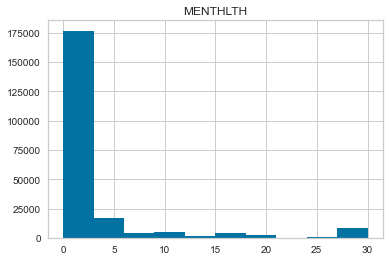

In [16]:
# Look at histogram of target (MENTHLTH) to decide bin ranges
health_df.hist(column='MENTHLTH')

In [17]:
# Create 2 bins for mental health. One at 0, one from 1-30
health_df['MENTHLTH'] = health_df['MENTHLTH'].replace({30:1, 29:1, 28:1, 27:1, 26:1, 25:1, 24:1, 23:1, 22:1, 21:1,
                                                       20:1, 19:1, 18:1, 17:1, 16:1, 15:1, 14:1, 13:1, 12:1, 11:1,
                                                       10:1, 9:1, 8:1, 7:1, 6:1, 5:1, 4:1, 3:1, 2:1})

array([[<AxesSubplot:title={'center':'MENTHLTH'}>]], dtype=object)

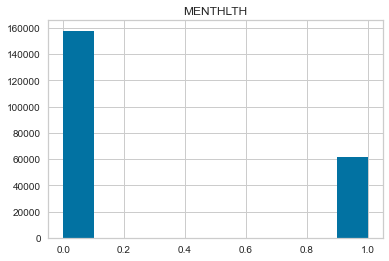

In [18]:
# Check target column bins
health_df.hist(column='MENTHLTH')

In [19]:
# Check which features need to be binned in the pycaret setup (over 12 unique values)
print(health_df.nunique())

GENHLTH                     5
MENTHLTH                    2
PHYSHLTH                   31
SEX                         2
MARITAL_STATUS              6
EDUCATION                   6
HOME_STATUS                 3
VETERAN                     2
EMPLOYMENT_SITUATION        7
INTERNET                    2
DISABILITIES?               2
USEEQUIP                    2
BLIND                       2
ISSUES_DECISION_MAING       4
DIFFWALK                    2
DIFFDRES                    2
DIFFALON                    2
HEALTHY_ADULTS              2
HEALTH_CVRAGE               2
DIABETE3                    4
BLOOD_PRESSURE              2
_CHOLCHK                    2
HIGH_CHOLESTEROL            2
CORONARY_DISEASE            2
ASTHMA_DISEASE              2
_ASTHMS1                    4
HAS_ARTHRITIS               2
RACE                        9
AGE_14LEVEL                12
BMI                      2870
4_BMI                       4
CHILDREN2                   6
EDUCATION_LEVEL             4
INCOME2   

In [20]:
# Save cleaned health_df to csv
health_df.to_csv("cleaned_health_df")

## Feature Selection

In [21]:
# PyCaret Setup
# "Normalize = True" scales the data based on z-score
# "transformation = True" changes the shape of the distribution to approximately normal
# "fix_imbalance uses SMOTE to balance target variable"
# "bin_numeric_features" creates bins for continuous categorical features based on sturges rule and K-means clusters
exp_clf101 = setup(data = health_df, target = 'MENTHLTH', session_id=123,
                   normalize = True,
                   transformation = True,
                   fix_imbalance = True,
                   bin_numeric_features = ['PHYSHLTH', 'BMI', 'PHYS_ACTIVITY_MINS', 'DRINKS_WEEK'])

,Description,Value
0,Session id,123
1,Target,MENTHLTH
2,Target type,Binary
3,Original data shape,"(219562, 42)"
4,Transformed data shape,"(286789, 42)"
5,Transformed train set shape,"(220920, 42)"
6,Transformed test set shape,"(65869, 42)"
7,Numeric features,41
8,Preprocess,True
9,Imputation type,simple


In [22]:
# Create a random forest classifier (runtime ~10min)
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7441,0.7094,0.3053,0.5869,0.4016,0.2590,0.2814
1,0.7532,0.7173,0.3272,0.6152,0.4272,0.2882,0.3115
2,0.7465,0.7139,0.3131,0.5936,0.4100,0.2677,0.2899
3,0.7499,0.7147,0.3234,0.6034,0.4211,0.2797,0.3018
4,0.7485,0.7099,0.3276,0.5965,0.4229,0.2791,0.2996
5,0.7475,0.7106,0.3192,0.5953,0.4156,0.2728,0.2944
6,0.7494,0.7123,0.3208,0.6023,0.4187,0.2774,0.2997
7,0.7438,0.7077,0.3220,0.5805,0.4142,0.2671,0.2861
8,0.7470,0.7114,0.3195,0.5932,0.4153,0.2719,0.2931


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

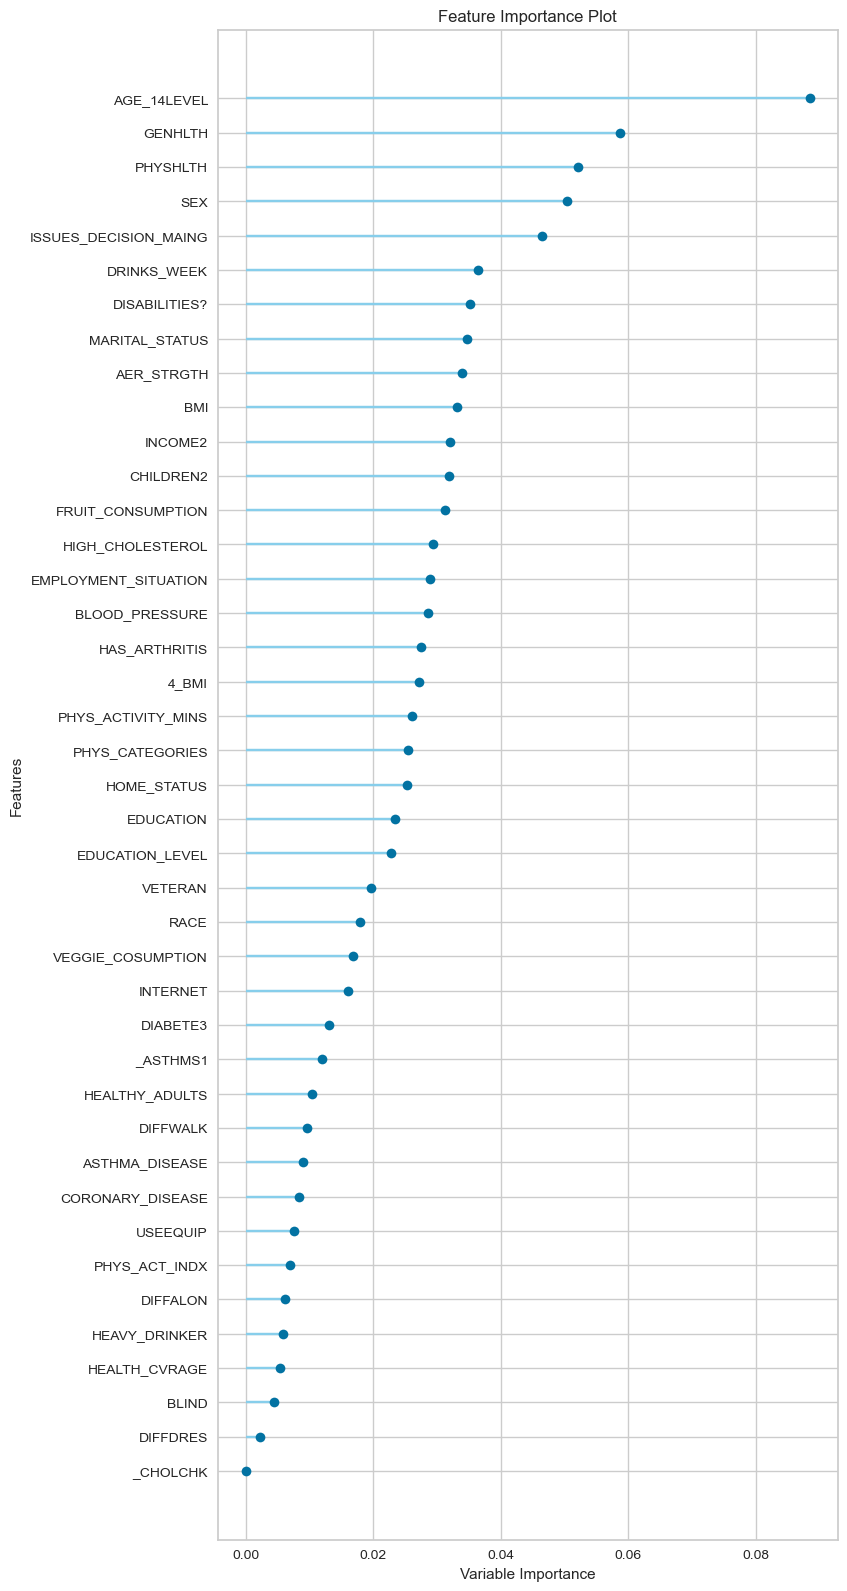

In [23]:
# Feature importance plot
plot_model(rf, plot='feature_all')

In [24]:
# Keep only 23 highest features (over 0.02 variable importance)
lowest_features = ['_CHOLCHK','HEAVY_DRINKER','HEALTH_CVRAGE','DIFFDRES','BLIND','DIFFALON','PHYS_ACT_INDX','USEEQUIP',
                   'CORONARY_DISEASE','ASTHMA_DISEASE','HEALTHY_ADULTS','DIFFWALK','_ASTHMS1','DIABETE3','INTERNET',
                   'VEGGIE_COSUMPTION','RACE','VETERAN']

fs_health_df = health_df.drop(columns=lowest_features)

## Split Data

In [25]:
# Separate data into training and testing sets
data = fs_health_df.sample(frac=0.90, random_state=123).reset_index(drop=True)
data_unseen = fs_health_df.drop(data.index, errors='ignore').reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (197606, 24)
Unseen Data For Predictions: (24315, 24)


In [26]:
# PyCaret Setup
# "normalize = True" scales the data based on z-score
# "transformation = True" changes the shape of the distribution to approximately normal
# "fix_imbalance uses SMOTE to balance target variable"
# "bin_numeric_features" creates bins for continuous categorical features based on sturges rule and K-means clusters
exp_clf101 = setup(data = data, 
                   target = 'MENTHLTH',
                   session_id=123,
                   normalize = True,
                   transformation = True,
                   fix_imbalance = True,
                   bin_numeric_features = ['PHYSHLTH', 'BMI', 'PHYS_ACTIVITY_MINS', 'DRINKS_WEEK'])

,Description,Value
0,Session id,123
1,Target,MENTHLTH
2,Target type,Binary
3,Original data shape,"(197606, 24)"
4,Transformed data shape,"(258222, 24)"
5,Transformed train set shape,"(198940, 24)"
6,Transformed test set shape,"(59282, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


## Compare Binary Classification Machine Learning Models

In [27]:
# Model training and selection (runtime ~35min)
best_model = compare_models(exclude = 'knn')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7597,0.7405,0.3015,0.6579,0.4135,0.2877,0.3224,1.9210
gbc,Gradient Boosting Classifier,0.7542,0.7367,0.3535,0.6076,0.4469,0.3028,0.3212,9.9530
rf,Random Forest Classifier,0.7407,0.7038,0.3287,0.5663,0.4159,0.2641,0.2803,8.5580
et,Extra Trees Classifier,0.7320,0.6897,0.3399,0.5362,0.4160,0.2533,0.2644,16.0150
ada,Ada Boost Classifier,0.7287,0.7271,0.4758,0.5191,0.4963,0.3113,0.3119,3.0120
qda,Quadratic Discriminant Analysis,0.7230,0.7229,0.4995,0.5070,0.5032,0.3111,0.3112,0.3280
dummy,Dummy Classifier,0.7191,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1840
nb,Naive Bayes,0.7051,0.7047,0.5028,0.4763,0.4892,0.2821,0.2823,0.5510
svm,SVM - Linear Kernel,0.6913,0.0000,0.6005,0.4624,0.5222,0.2999,0.3057,0.4360
lda,Linear Discriminant Analysis,0.6886,0.7327,0.6242,0.4599,0.5296,0.3047,0.3127,0.3940


Processing:   0%|          | 0/49 [00:00<?, ?it/s]

In [28]:
# Create gradient boosting classifier model
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7513,0.7313,0.3536,0.5969,0.4441,0.2972,0.3141
1,0.7467,0.7331,0.3469,0.5825,0.4348,0.2849,0.3008
2,0.7510,0.7290,0.3497,0.5971,0.4411,0.2947,0.3122
3,0.7595,0.7467,0.3613,0.6243,0.4577,0.3170,0.3366
4,0.7585,0.7383,0.3565,0.6225,0.4534,0.3128,0.3328
5,0.7557,0.7370,0.3421,0.6176,0.4403,0.3001,0.3216
6,0.7572,0.7387,0.3580,0.6169,0.4531,0.3109,0.3299
7,0.7587,0.7395,0.3586,0.6222,0.4549,0.3141,0.3337
8,0.7505,0.7327,0.3516,0.5944,0.4419,0.2946,0.3114


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## Tune Model and Analyze Performance

In [41]:
# Automatically tune model parameters using PyCaret (runtime ~50min)
tuned_gbc = tune_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7543,0.7251,0.3157,0.6238,0.4193,0.2841,0.3106
1,0.7489,0.7261,0.3134,0.6021,0.4123,0.2723,0.2957
2,0.7538,0.7233,0.3026,0.6282,0.4085,0.2763,0.3057
3,0.7630,0.7433,0.3325,0.6538,0.4408,0.3102,0.3387
4,0.7586,0.7287,0.3151,0.6435,0.4230,0.2924,0.3222
5,0.7536,0.7286,0.3012,0.6280,0.4071,0.2751,0.3047
6,0.7589,0.7335,0.3194,0.6423,0.4267,0.2952,0.3241
7,0.7553,0.7300,0.3094,0.6316,0.4153,0.2829,0.3117
8,0.7564,0.7265,0.3194,0.6309,0.4241,0.2901,0.3171


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [42]:
# Display hyperparameters of tuned model
print(tuned_gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=7,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_samples_leaf=4,
                           min_samples_split=10, min_weight_fraction_leaf=0.0,
                           n_estimators=190, n_iter_no_change=None,
                           random_state=123, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [43]:
# Save the model
save_model(tuned_gbc,'Final_GBC_Model_13Sep22')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\kylie\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['GENHLTH', 'PHYSHLTH', 'SEX',
                                              'MARITAL_STATUS', 'EDUCATION',
                                              'HOME_STATUS',
                                              'EMPLOYMENT_SITUATION',
                                              'DISABILITIES?',
                                              'ISSUES_DECISION_MAING',
                                              'BLOOD_PRESSURE',
                                              'HIGH_CHOLESTEROL',
                                              'HAS_ARTHRITIS', 'AGE_14LEVEL',
                                              'BMI', '4...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.4, los

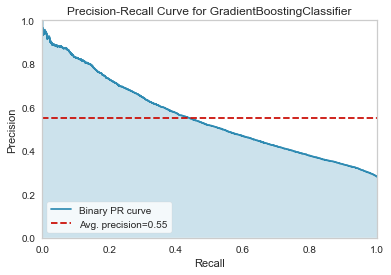

In [44]:
# Learning Curve
plot_model(tuned_gbc, plot = 'pr')

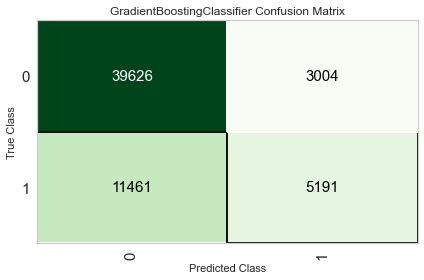

In [45]:
# Confusion Matrix
plot_model(tuned_gbc, plot = 'confusion_matrix')

In [46]:
# Predict using held-back test sample
predict_model(tuned_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7560,0.7297,0.3117,0.6334,0.4178,0.2854,0.3142
